# Trax Quick Intro

[Trax](https://trax-ml.readthedocs.io/en/latest/) is an end-to-end library for deep learning that focuses on clear code and speed. It is actively used and maintained in the [Google Brain team](https://research.google.com/teams/brain/). This notebook ([run it in colab](https://colab.research.google.com/github/google/trax/blob/master/trax/intro.ipynb)) shows how to use Trax and where you can find more information.

  1. **Run a pre-trained Transformer**: create a translator in a few lines of code
  1. **Features and resources**: [API docs](https://trax-ml.readthedocs.io/en/latest/trax.html), where to [talk to us](https://gitter.im/trax-ml/community), how to [open an issue](https://github.com/google/trax/issues) and more
  1. **Walkthrough**: how Trax works, how to make new models and train on your own data

We welcome **contributions** to Trax! We welcome PRs with code for new models and layers as well as improvements to our code and documentation. We especially love **notebooks** that explain how models work and show how to use them to solve problems!




**General Setup**

Execute the following few cells (once) before running any of the code samples.

In [1]:
#@title
# Copyright 2020 Google LLC.

# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at

# https://www.apache.org/licenses/LICENSE-2.0

# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import os
import numpy as np




In [2]:
#@title
# Import Trax

!pip install -q -U trax
import trax


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 637.9/637.9 kB 14.6 MB/s eta 0:00:00


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


## 1. Run a pre-trained Transformer

Here is how you create an Engligh-German translator in a few lines of code:

* create a Transformer model in Trax with [trax.models.Transformer](https://trax-ml.readthedocs.io/en/latest/trax.models.html#trax.models.transformer.Transformer)
* initialize it from a file with pre-trained weights with [model.init_from_file](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.base.Layer.init_from_file)
* tokenize your input sentence to input into the model with [trax.data.tokenize](https://trax-ml.readthedocs.io/en/latest/trax.data.html#trax.data.tf_inputs.tokenize)
* decode from the Transformer with [trax.supervised.decoding.autoregressive_sample](https://trax-ml.readthedocs.io/en/latest/trax.supervised.html#trax.supervised.decoding.autoregressive_sample)
* de-tokenize the decoded result to get the translation with [trax.data.detokenize](https://trax-ml.readthedocs.io/en/latest/trax.data.html#trax.data.tf_inputs.detokenize)


In [3]:

# Create a Transformer model.
# Pre-trained model config in gs://trax-ml/models/translation/ende_wmt32k.gin
model = trax.models.Transformer(
    input_vocab_size=33300,
    d_model=512, d_ff=2048,
    n_heads=8, n_encoder_layers=6, n_decoder_layers=6,
    max_len=2048, mode='predict')

# Initialize using pre-trained weights.
model.init_from_file('gs://trax-ml/models/translation/ende_wmt32k.pkl.gz',
                     weights_only=True)

# Tokenize a sentence.
sentence = 'It is nice to learn new things today!'
tokenized = list(trax.data.tokenize(iter([sentence]),  # Operates on streams.
                                    vocab_dir='gs://trax-ml/vocabs/',
                                    vocab_file='ende_32k.subword'))[0]

# Decode from the Transformer.
tokenized = tokenized[None, :]  # Add batch dimension.
tokenized_translation = trax.supervised.decoding.autoregressive_sample(
    model, tokenized, temperature=0.0)  # Higher temperature: more diverse results.

# De-tokenize,
tokenized_translation = tokenized_translation[0][:-1]  # Remove batch and EOS.
translation = trax.data.detokenize(tokenized_translation,
                                   vocab_dir='gs://trax-ml/vocabs/',
                                   vocab_file='ende_32k.subword')
print(translation)

Es ist schön, heute neue Dinge zu lernen!


/tmp/ipython-input-3345520701.py:8: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')
/tmp/ipython-input-3345520701.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # 自动调整布局避免重叠


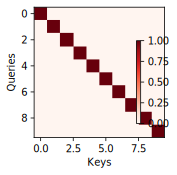

In [6]:
import matplotlib.pyplot as plt
from IPython import display  # 用于设置SVG显示（若在Jupyter环境）

def show_heatmaps(matrices, xlabel, ylabel, titles=None, figsize=(2.5, 2.5),
                  cmap='Reds', xticks=None, yticks=None):
    """显示矩阵热图（使用matplotlib替代d2l库）"""
    # 设置SVG显示格式（适合高清显示和Jupyter环境）
    display.set_matplotlib_formats('svg')
    plt.rcParams['svg.fonttype'] = 'none'  # 确保SVG中的文字可编辑

    # 获取子图网格的行数和列数
    num_rows, num_cols = matrices.shape[0], matrices.shape[1]

    # 创建子图网格
    fig, axes = plt.subplots(
        num_rows, num_cols,
        figsize=figsize,
        sharex=True,  # 共享x轴刻度
        sharey=True,  # 共享y轴刻度
        squeeze=False  # 确保axes始终为二维数组
    )

    # 遍历每个子图并绘制热图
    for i, (row_axes, row_matrices) in enumerate(zip(axes, matrices)):
        for j, (ax, matrix) in enumerate(zip(row_axes, row_matrices)):
            # 将TensorFlow张量转换为numpy数组并绘制
            pcm = ax.imshow(matrix.numpy(), cmap=cmap)

            # 设置坐标轴刻度
            if xticks is not None:
                ax.set_xticks(xticks)
            if yticks is not None:
                ax.set_yticks(yticks)

            # 仅在最后一行设置x轴标签
            if i == num_rows - 1:
                ax.set_xlabel(xlabel)
            # 仅在第一列设置y轴标签
            if j == 0:
                ax.set_ylabel(ylabel)
            # 设置标题（若提供）
            if titles:
                ax.set_title(titles[j])

    # 添加颜色条（调整大小适配子图）
    fig.colorbar(pcm, ax=axes, shrink=0.6)

    # 显示图像
    plt.tight_layout()  # 自动调整布局避免重叠
    plt.show()
# attention_weights = tf.reshape(tf.eye(10), (1, 1, 10, 10))
attention_weights = tf.reshape(tokenized, (1, 1, 10, 10))

show_heatmaps(attention_weights, xlabel='Keys', ylabel='Queries')

## 2. Features and resources

Trax includes basic models (like [ResNet](https://github.com/google/trax/blob/master/trax/models/resnet.py#L70), [LSTM](https://github.com/google/trax/blob/master/trax/models/rnn.py#L100), [Transformer](https://github.com/google/trax/blob/master/trax/models/transformer.py#L189) and RL algorithms
(like [REINFORCE](https://github.com/google/trax/blob/master/trax/rl/training.py#L244), [A2C](https://github.com/google/trax/blob/master/trax/rl/actor_critic_joint.py#L458), [PPO](https://github.com/google/trax/blob/master/trax/rl/actor_critic_joint.py#L209)). It is also actively used for research and includes
new models like the [Reformer](https://github.com/google/trax/tree/master/trax/models/reformer) and new RL algorithms like [AWR](https://arxiv.org/abs/1910.00177). Trax has bindings to a large number of deep learning datasets, including
[Tensor2Tensor](https://github.com/tensorflow/tensor2tensor) and [TensorFlow datasets](https://www.tensorflow.org/datasets/catalog/overview).


You can use Trax either as a library from your own python scripts and notebooks
or as a binary from the shell, which can be more convenient for training large models.
It runs without any changes on CPUs, GPUs and TPUs.

* [API docs](https://trax-ml.readthedocs.io/en/latest/)
* [chat with us](https://gitter.im/trax-ml/community)
* [open an issue](https://github.com/google/trax/issues)
* subscribe to [trax-discuss](https://groups.google.com/u/1/g/trax-discuss) for news



## 3. Walkthrough

You can learn here how Trax works, how to create new models and how to train them on your own data.

### Tensors and Fast Math

The basic units flowing through Trax models are *tensors* - multi-dimensional arrays, sometimes also known as numpy arrays, due to the most widely used package for tensor operations -- `numpy`. You should take a look at the [numpy guide](https://numpy.org/doc/stable/user/quickstart.html) if you don't know how to operate on tensors: Trax also uses the numpy API for that.

In Trax we want numpy operations to run very fast, making use of GPUs and TPUs to accelerate them. We also want to automatically compute gradients of functions on tensors. This is done in the `trax.fastmath` package thanks to its backends -- [JAX](https://github.com/google/jax) and [TensorFlow numpy](https://tensorflow.org).

In [ ]:
from trax.fastmath import numpy as fastnp
trax.fastmath.use_backend('jax')  # Can be 'jax' or 'tensorflow-numpy'.

matrix = fastnp.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
print(f'matrix =\n{matrix}')
vector = fastnp.ones(3)
print(f'vector = {vector}')
product = fastnp.dot(vector, matrix)
print(f'product = {product}')
tanh = fastnp.tanh(product)
print(f'tanh(product) = {tanh}')

matrix =
[[1 2 3]
 [4 5 6]
 [7 8 9]]
vector = [1. 1. 1.]
product = [12. 15. 18.]
tanh(product) = [0.99999994 0.99999994 0.99999994]


Gradients can be calculated using `trax.fastmath.grad`.

In [ ]:
def f(x):
  return 2.0 * x * x

grad_f = trax.fastmath.grad(f)

print(f'grad(2x^2) at 1 = {grad_f(1.0)}')
print(f'grad(2x^2) at -2 = {grad_f(-2.0)}')

grad(2x^2) at 1 = 4.0
grad(2x^2) at -2 = -8.0


### Layers

Layers are basic building blocks of Trax models. You will learn all about them in the [layers intro](https://trax-ml.readthedocs.io/en/latest/notebooks/layers_intro.html) but for now, just take a look at the implementation of one core Trax layer, `Embedding`:

```
class Embedding(base.Layer):
  """Trainable layer that maps discrete tokens/IDs to vectors."""

  def __init__(self,
               vocab_size,
               d_feature,
               kernel_initializer=init.RandomNormalInitializer(1.0)):
    """Returns an embedding layer with given vocabulary size and vector size.

    Args:
      vocab_size: Size of the input vocabulary. The layer will assign a unique
          vector to each id in `range(vocab_size)`.
      d_feature: Dimensionality/depth of the output vectors.
      kernel_initializer: Function that creates (random) initial vectors for
          the embedding.
    """
    super().__init__(name=f'Embedding_{vocab_size}_{d_feature}')
    self._d_feature = d_feature  # feature dimensionality
    self._vocab_size = vocab_size
    self._kernel_initializer = kernel_initializer

  def forward(self, x):
    """Returns embedding vectors corresponding to input token IDs.

    Args:
      x: Tensor of token IDs.

    Returns:
      Tensor of embedding vectors.
    """
    return jnp.take(self.weights, x, axis=0, mode='clip')

  def init_weights_and_state(self, input_signature):
    """Randomly initializes this layer's weights."""
    del input_signature
    shape_w = (self._vocab_size, self._d_feature)
    w = self._kernel_initializer(shape_w, self.rng)
    self.weights = w
```

Layers with trainable weights like `Embedding` need to be initialized with the signature (shape and dtype) of the input, and then can be run by calling them.


In [ ]:
from trax import layers as tl

# Create an input tensor x.
x = np.arange(15)
print(f'x = {x}')

# Create the embedding layer.
embedding = tl.Embedding(vocab_size=20, d_feature=32)
embedding.init(trax.shapes.signature(x))

# Run the layer -- y = embedding(x).
y = embedding(x)
print(f'shape of y = {y.shape}')

x = [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
shape of y = (15, 32)


### Models

Models in Trax are built from layers most often using the `Serial` and `Branch` combinators. You can read more about those combinators in the [layers intro](https://trax-ml.readthedocs.io/en/latest/notebooks/layers_intro.html) and
see the code for many models in `trax/models/`, e.g., this is how the [Transformer Language Model](https://github.com/google/trax/blob/master/trax/models/transformer.py#L167) is implemented. Below is an example of how to build a sentiment classification model.

In [ ]:
model = tl.Serial(
    tl.Embedding(vocab_size=8192, d_feature=256),
    tl.Mean(axis=1),  # Average on axis 1 (length of sentence).
    tl.Dense(2),      # Classify 2 classes.
)

# You can print model structure.
print(model)

Serial[
  Embedding_8192_256
  Mean
  Dense_2
]


### Data

To train your model, you need data. In Trax, data streams are represented as python iterators, so you can call `next(data_stream)` and get a tuple, e.g., `(inputs, targets)`. Trax allows you to use [TensorFlow Datasets](https://www.tensorflow.org/datasets) easily and you can also get an iterator from your own text file using the standard `open('my_file.txt')`.

In [ ]:
train_stream = trax.data.TFDS('imdb_reviews', keys=('text', 'label'), train=True)()
eval_stream = trax.data.TFDS('imdb_reviews', keys=('text', 'label'), train=False)()
print(next(train_stream))  # See one example.

(b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.", 0)


Using the `trax.data` module you can create input processing pipelines, e.g., to tokenize and shuffle your data. You create data pipelines using `trax.data.Serial` and they are functions that you apply to streams to create processed streams.

In [ ]:
data_pipeline = trax.data.Serial(
    trax.data.Tokenize(vocab_file='en_8k.subword', keys=[0]),
    trax.data.Shuffle(),
    trax.data.FilterByLength(max_length=2048, length_keys=[0]),
    trax.data.BucketByLength(boundaries=[  32, 128, 512, 2048],
                             batch_sizes=[512, 128,  32,    8, 1],
                             length_keys=[0]),
    trax.data.AddLossWeights()
  )
train_batches_stream = data_pipeline(train_stream)
eval_batches_stream = data_pipeline(eval_stream)
example_batch = next(train_batches_stream)
print(f'shapes = {[x.shape for x in example_batch]}')  # Check the shapes.

shapes = [(8, 2048), (8,), (8,)]


### Supervised training

When you have the model and the data, use `trax.supervised.training` to define training and eval tasks and create a training loop. The Trax training loop optimizes training and will create TensorBoard logs and model checkpoints for you.

In [ ]:
from trax.supervised import training

# Training task.
train_task = training.TrainTask(
    labeled_data=train_batches_stream,
    loss_layer=tl.WeightedCategoryCrossEntropy(),
    optimizer=trax.optimizers.Adam(0.01),
    n_steps_per_checkpoint=500,
)

# Evaluaton task.
eval_task = training.EvalTask(
    labeled_data=eval_batches_stream,
    metrics=[tl.WeightedCategoryCrossEntropy(), tl.WeightedCategoryAccuracy()],
    n_eval_batches=20  # For less variance in eval numbers.
)

# Training loop saves checkpoints to output_dir.
output_dir = os.path.expanduser('~/output_dir/')
!rm -rf {output_dir}
training_loop = training.Loop(model,
                              train_task,
                              eval_tasks=[eval_task],
                              output_dir=output_dir)

# Run 2000 steps (batches).
training_loop.run(2000)


Step      1: Total number of trainable weights: 2097666
Step      1: Ran 1 train steps in 1.15 secs
Step      1: train WeightedCategoryCrossEntropy |  0.69192106
Step      1: eval  WeightedCategoryCrossEntropy |  0.69349981
Step      1: eval      WeightedCategoryAccuracy |  0.50312500

Step    500: Ran 499 train steps in 10.62 secs
Step    500: train WeightedCategoryCrossEntropy |  0.50712883
Step    500: eval  WeightedCategoryCrossEntropy |  0.42969493
Step    500: eval      WeightedCategoryAccuracy |  0.81406250

Step   1000: Ran 500 train steps in 8.89 secs
Step   1000: train WeightedCategoryCrossEntropy |  0.35916388
Step   1000: eval  WeightedCategoryCrossEntropy |  0.41775789
Step   1000: eval      WeightedCategoryAccuracy |  0.79531250

Step   1500: Ran 500 train steps in 9.13 secs
Step   1500: train WeightedCategoryCrossEntropy |  0.35241464
Step   1500: eval  WeightedCategoryCrossEntropy |  0.35194683
Step   1500: eval      WeightedCategoryAccuracy |  0.85117188

Step   2000:

After training the model, run it like any layer to get results.

In [ ]:
example_input = next(eval_batches_stream)[0][0]
example_input_str = trax.data.detokenize(example_input, vocab_file='en_8k.subword')
print(f'example input_str: {example_input_str}')
sentiment_log_probs = model(example_input[None, :])  # Add batch dimension.
print(f'Model returned sentiment probabilities: {np.exp(sentiment_log_probs)}')

example input_str: There are a few aspects to Park's movies, and in particular Wallace & Gromit, that I would say make them so great. The first is subtlety and observation, the flagship of which is the character of Gromit. He doesn't speak, he doesn't make any noise, all he has are his eyes, brow, and body posture, and with these he commands the film. Park manages to give us everything we need from this silent character through his expression. The comedy and the emotion is conveyed through the subtlest of movements and it works superbly well.<br /><br />Watching the movie you have to be aware of the entire screen. Normally you'll be guided to things in the movies, the screen won't be cluttered too much, there won't be many things to take your eyes away from the main clue or action. Park seems to need to look the other way with his movies. He throws extra content at his audience, there's action in the background, to the side of the screen, even off screen, and there's just about always 